In [16]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import mean_squared_log_error
# WHEN CHECKING THE MODEL: use as np.sqrt(mean_squared_log_error( y_test, predictions ))
from pandas.tseries.holiday import USFederalHolidayCalendar
import seaborn as seabornInstance 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn import metrics
from sklearn import tree
from sklearn import preprocessing
%matplotlib inline

---
# Load the Data

### Building and Weather Data

In [2]:
# Note: These assume that the data has been saved to a subdirectory named "energy"
bldgData = pd.read_csv("energy/building_metadata.csv")
weatherTrain = pd.read_csv("energy/weather_train.csv")
weatherTest = pd.read_csv("energy/weather_test.csv")
allWeather = weatherTrain.append(weatherTest)

### Training Data

In [3]:
energyTrain = pd.read_csv("energy/train.csv")

### Test Data
Warning: This will use a lot of memory! My virtual machine is sitting at 5.5 GB of RAM utilization right now.

In [4]:
energyTest = pd.read_csv("energy/test.csv")

### Explore the Data

In [7]:
print(energyTest.shape)
print(energyTrain.shape)

(41697600, 4)
(20216100, 4)


In [5]:
trainJoinBldg = pd.merge(energyTrain, bldgData, on='building_id')
fullTraining = pd.merge(trainJoinBldg, allWeather, how='left', on=['site_id', 'timestamp'])

In [89]:
# Explore new dataframes
print(energyTrain.shape)
print(trainJoinBldg.shape)
thrownOut = energyTrain.shape[0] - trainJoinBldg.shape[0]
thrownOutPercent = 100.* thrownOut * 1./ energyTrain.shape[0]
print("% thrown out by merging with building data: " + '{0:.2f}'.format(thrownOutPercent) + "%")
print(fullTraining.shape)
thrownOut = trainJoinBldg.shape[0] - fullTraining.shape[0]
thrownOutPercent = 100.* thrownOut * 1./ trainJoinBldg.shape[0]
print("% thrown out by merging with weather data: " + '{0:.2f}'.format(thrownOutPercent) + "%")
#print(trainJoinBldg.head(5))
#print(fullTraining.head(5))
print(fullTraining.columns)

(20216100, 4)
(20216100, 9)
% thrown out by merging with building data: 0.00%
(20216100, 16)
% thrown out by merging with weather data: 0.00%
Index(['building_id', 'meter', 'timestamp', 'meter_reading', 'site_id',
       'primary_use', 'square_feet', 'year_built', 'floor_count',
       'air_temperature', 'cloud_coverage', 'dew_temperature',
       'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction',
       'wind_speed'],
      dtype='object')


`fullTraining` now has all the provided training data merged into one dataframe. i.e. Each row contains the meter reading, building info, and weather for that site+timestamp all in one row.

Only 0.45% of the rows get lost when merging with the weather data. This implies that not every site+timestamp is present in the weather data.

I assume it will also be necessary to repeat these steps for the test data prior to making predictions; however, if weather data is not present for a given site+timestamp, we cannot just drop the row - we must still make a prediction.

---
# 2. Linear Regression

I have a hunch that we'll need separate models for workdays and holidays/weekends.
So, we may end up needing a model for each of the following:

* workday / electricity
* workday / chilledwater
* workday / steam
* workday / hotwater
* non-workday / electricity
* non-workday / chilledwater
* non-workday / steam
* non-workday / hotwater

And we could maybe even add the `primary_use` as yet another variable if we really want/need to.

---
# 2. Sample General Linear Regression Model

In [8]:
#Splitting into features and labels
X = fullTraining2[['square_feet', 'year_built', 'floor_count', 'air_temperature', 'cloud_coverage', 'dew_temperature', 'sea_level_pressure', 'wind_direction', 'wind_speed']].values
y = fullTraining2['meter_reading'].values

#replace null values with column means
indsX = np.where(np.isnan(X))
col_mean = np.nanmean(X, axis=1)
X[indsX] = np.take(col_mean, indsX[1])

In [7]:
regressor = LinearRegression()
regressor.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

## Coefficients

In [8]:
coeff_df = pd.DataFrame(regressor.coef_, [['square_feet', 'year_built', 'floor_count', 'air_temperature', 'cloud_coverage', 'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction', 'wind_speed']], columns=['Coefficient'])  
coeff_df

,Coefficient
square_feet,0.032131
year_built,-2.459565
floor_count,1.107654
air_temperature,2.129612
cloud_coverage,0.062166
dew_temperature,-7.816598
precip_depth_1_hr,-0.168671
sea_level_pressure,0.126288
wind_direction,-0.347320
wind_speed,-0.078368


---
# Testing General Linear Regression Model

In [9]:
testJoinBldg = pd.merge(energyTest, bldgData, on='building_id')
fullTesting = pd.merge(testJoinBldg, allWeather, how='left', on=['site_id', 'timestamp'])

In [10]:
X_test = fullTesting[['square_feet', 'year_built', 'floor_count', 'air_temperature', 'cloud_coverage', 'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction', 'wind_speed']].values
#X_test = fullTesting[['air_temperature', 'dew_temperature']].values

In [11]:
inds = np.where(np.isnan(X_test))

In [12]:
col_mean = np.nanmean(X_test, axis=1)
X_test[inds] = np.take(col_mean, inds[1])

In [13]:
y_pred = regressor.predict(X_test)

In [16]:
print(y_pred[:5])

[-3681.90173244 -3823.46345567 -3706.14990701 -3144.92365245
   -92.86407147]


In [15]:
print(X_test[:5])

[[7.4320000e+03 2.0080000e+03 1.0656875e+03 1.7800000e+01 4.0000000e+00
  1.1700000e+01 3.8831875e+03 1.0214000e+03 1.0000000e+02 3.6000000e+00]
 [2.7200000e+03 2.0040000e+03 1.0656875e+03 1.7800000e+01 4.0000000e+00
  1.1700000e+01 3.8831875e+03 1.0214000e+03 1.0000000e+02 3.6000000e+00]
 [5.3760000e+03 1.9910000e+03 1.0656875e+03 1.7800000e+01 4.0000000e+00
  1.1700000e+01 3.8831875e+03 1.0214000e+03 1.0000000e+02 3.6000000e+00]
 [2.3685000e+04 2.0020000e+03 1.0656875e+03 1.7800000e+01 4.0000000e+00
  1.1700000e+01 3.8831875e+03 1.0214000e+03 1.0000000e+02 3.6000000e+00]
 [1.1660700e+05 1.9750000e+03 1.0656875e+03 1.7800000e+01 4.0000000e+00
  1.1700000e+01 3.8831875e+03 1.0214000e+03 1.0000000e+02 3.6000000e+00]]


---
# 2. Sample General Linear Regression Model 2 - feature manipulation

In [135]:
fullTraining2 = fullTraining
airTempMean = fullTraining2['air_temperature'].mean()
fullTraining2['air_temperature'] - airTempMean
fullTraining2['air_temperature'] = fullTraining2['air_temperature'].abs()
dewTempMean = fullTraining2['dew_temperature'].mean()
fullTraining2['dew_temperature'] - dewTempMean
fullTraining2['dew_temperature'] = fullTraining2['dew_temperature'].abs()
fullTraining2['year_built'] = 2019 - fullTraining2['year_built']

In [136]:
#Splitting into features and labels
X = fullTraining2[['year_built', 'air_temperature', 'dew_temperature']].values
y = fullTraining2['meter_reading'].values

#replace null values with column means
indsX = np.where(np.isnan(X))
col_mean = np.nanmean(X, axis=1)
X[indsX] = np.take(col_mean, indsX[1])

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice
  import sys


In [137]:
print(X.shape)
print(y.shape)

(20216100, 3)
(20216100,)


In [138]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [139]:
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

## Coefficients

In [140]:
coeff_df = pd.DataFrame(regressor.coef_, [['year_built', 'air_temperature', 'dew_temperature']], columns=['Coefficient'])  
#coeff_df = pd.DataFrame(regressor.coef_, [['air_temperature', 'dew_temperature']], columns=['Coefficient'])  
coeff_df

,Coefficient
year_built,-2.335449
air_temperature,-1.368348
dew_temperature,-2.063452


In [141]:
y_pred = regressor.predict(X_test)

In [142]:
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df1 = df.head(25)
df1

,Actual,Predicted
0,109.0000,3348.859663
1,17.4250,3346.646260
2,4.1231,417.346824
3,1089.8000,3342.871281
4,82.9440,316.509866
5,65.4333,3337.567073
6,6.0000,3288.800991
7,8.7921,315.398601
8,185.0000,3334.467967
9,0.3332,3351.902375


In [143]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 3783.9188629980654
Mean Squared Error: 23906148884.744812
Root Mean Squared Error: 154616.1339729616


---
# Testing Linear Regression Model 2

In [118]:
testJoinBldg = pd.merge(energyTest, bldgData, sort=True, on='building_id')
fullTesting2 = pd.merge(testJoinBldg, allWeather, sort=True, how='left', on=['site_id', 'timestamp'])

In [119]:
# Explore new dataframes
print(energyTest.shape)
print(testJoinBldg.shape)
thrownOut = energyTest.shape[0] - testJoinBldg.shape[0]
thrownOutPercent = 100.* thrownOut * 1./ energyTest.shape[0]
print("% thrown out by merging with building data: " + '{0:.2f}'.format(thrownOutPercent) + "%")
print(fullTesting2.shape)
thrownOut = testJoinBldg.shape[0] - fullTesting2.shape[0]
thrownOutPercent = 100.* thrownOut * 1./ trainJoinBldg.shape[0]
print("% thrown out by merging with weather data: " + '{0:.2f}'.format(thrownOutPercent) + "%")
#print(trainJoinBldg.head(5))
#print(fullTraining.head(5))
print(fullTesting2.columns)

(41697600, 4)
(41697600, 9)
% thrown out by merging with building data: 0.00%
(41697600, 16)
% thrown out by merging with weather data: 0.00%
Index(['row_id', 'building_id', 'meter', 'timestamp', 'site_id', 'primary_use',
       'square_feet', 'year_built', 'floor_count', 'air_temperature',
       'cloud_coverage', 'dew_temperature', 'precip_depth_1_hr',
       'sea_level_pressure', 'wind_direction', 'wind_speed'],
      dtype='object')


In [120]:
tempMean = fullTesting2['air_temperature'].mean()
fullTesting2['air_temperature'] - tempMean
fullTesting2['air_temperature'] = fullTesting2['air_temperature'].abs()
dewtempMean = fullTesting2['dew_temperature'].mean()
fullTesting2['dew_temperature'] - dewtempMean
fullTesting2['dew_temperature'] = fullTesting2['dew_temperature'].abs()
fullTesting2['year_built'] = 2019 - fullTesting2['year_built']

In [121]:
X_test = fullTesting2[['year_built', 'air_temperature', 'dew_temperature']].values
#X_test = fullTesting[['air_temperature', 'dew_temperature']].values

In [124]:
print(fullTesting2.shape)
print(X_test.shape)

(41697600, 16)
(41697600, 3)


In [125]:
inds = np.where(np.isnan(X_test))

In [126]:
col_mean = np.nanmean(X_test, axis=1)
X_test[inds] = np.take(col_mean, inds[1])

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.


In [127]:
y_test_pred = regressor.predict(X_test)

In [128]:
print(y_test_pred[:5])

[2870.51834273 2697.68288332 2135.96764022 2611.26515361 1444.62580256]


In [129]:
print(X_test[:5])

[[11.  17.8 11.7]
 [15.  17.8 11.7]
 [28.  17.8 11.7]
 [17.  17.8 11.7]
 [44.  17.8 11.7]]


In [130]:
row_ids = fullTesting2['row_id']
pred = pd.DataFrame(y_test_pred)
linear01 = pd.concat([row_ids, pred], axis=1)
linear01.columns = ['row_id', 'meter_reading']

In [131]:
print(linear01.head(5))
print(linear01.columns)
print(linear01.shape)
print(row_ids.head(5))

   row_id  meter_reading
0       0    2870.518343
1       1    2697.682883
2       2    2135.967640
3       3    2611.265154
4       4    1444.625803
Index(['row_id', 'meter_reading'], dtype='object')
(41697600, 2)
0    0
1    1
2    2
3    3
4    4
Name: row_id, dtype: int64


In [132]:
linear01.to_csv('linearRegression01.csv', index=False)

In [133]:
resultTest = pd.read_csv("linearRegression01.csv")
print(resultTest.head(5))

   row_id  meter_reading
0       0    2870.518343
1       1    2697.682883
2       2    2135.967640
3       3    2611.265154
4       4    1444.625803


In [134]:
print(resultTest.shape)

(41697600, 2)


# Feature Selection

In [62]:
fullTraining2 = fullTraining
airTempMean = fullTraining2['air_temperature'].mean()
fullTraining2['air_temperature'] - airTempMean
fullTraining2['air_temperature'] = fullTraining2['air_temperature'].abs()
dewTempMean = fullTraining2['dew_temperature'].mean()
fullTraining2['dew_temperature'] - dewTempMean
fullTraining2['dew_temperature'] = fullTraining2['dew_temperature'].abs()

In [63]:
#Splitting into features and labels
X = fullTraining2[['square_feet', 'year_built', 'floor_count', 'air_temperature', 'cloud_coverage', 'dew_temperature', 'sea_level_pressure', 'wind_direction', 'wind_speed']].values
#X = fullTraining[['air_temperature', 'dew_temperature']].values
y = fullTraining2['meter_reading'].values

#replace null values with column means
indsX = np.where(np.isnan(X))
col_mean = np.nanmean(X, axis=1)
X[indsX] = np.take(col_mean, indsX[1])

In [64]:
X_feat = pd.DataFrame(X)
y_feat = pd.DataFrame(y)

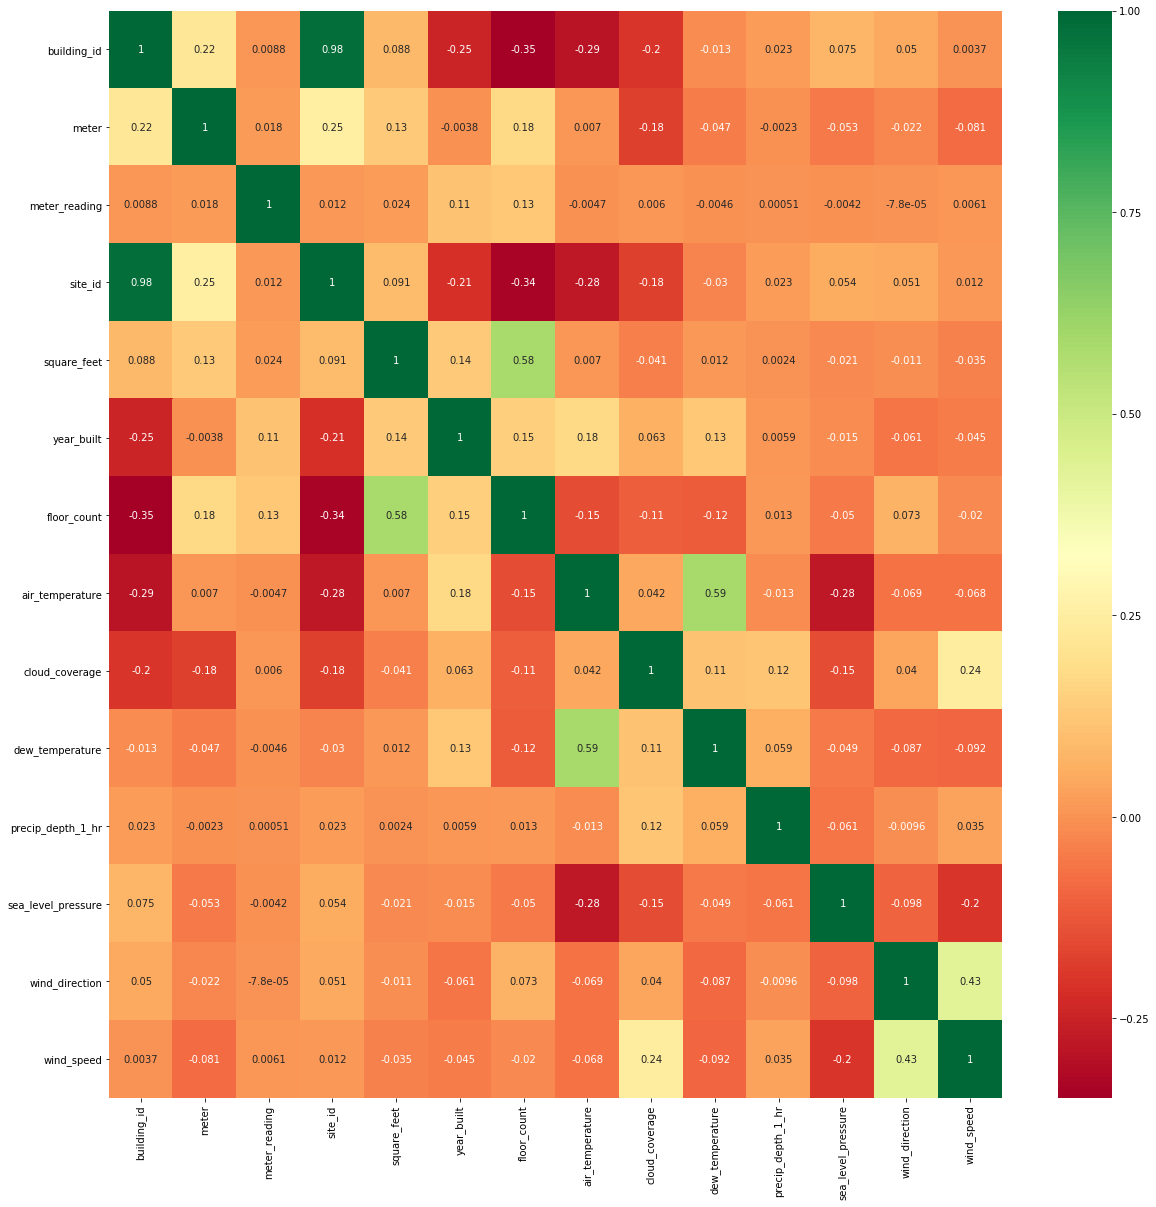

In [65]:
corrmat = fullTraining2.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=seabornInstance.heatmap(fullTraining2[top_corr_features].corr(),annot=True,cmap="RdYlGn")

# Linear Regression Model 3

In [69]:
fullTraining3 = fullTraining
fullTraining3['year_built'] = -fullTraining3['year_built'] + 2019
q = fullTraining3["meter_reading"].quantile(0.99)
fullTraining3 = fullTraining3[fullTraining3["meter_reading"] < q]
fullTraining3 = fullTraining3[fullTraining3["meter_reading"] > -q]
#fullTraining3['year_built'] = -fullTraining3['year_built'] + 2019

In [71]:
# Explore new dataframes
print(fullTraining.shape)
print(fullTraining3.shape)
thrownOut = fullTraining.shape[0] - fullTraining3.shape[0]
thrownOutPercent = 100.* thrownOut * 1./ fullTraining.shape[0]
print("% thrown out by merging with building data: " + '{0:.2f}'.format(thrownOutPercent) + "%")

(20216100, 16)
(20013897, 16)
% thrown out by merging with building data: 1.00%


In [72]:
#Splitting into features and labels
X = fullTraining3[['year_built', 'floor_count']].values
y = fullTraining3['meter_reading'].values

#replace null values with column means
indsX = np.where(np.isnan(X))
col_mean = np.nanmean(X, axis=1)
X[indsX] = np.take(col_mean, indsX[1])

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice
  import sys


In [73]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [74]:
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

## Coefficients

In [75]:
coeff_df = pd.DataFrame(regressor.coef_, [['year_built', 'floor_count']], columns=['Coefficient'])  
coeff_df

,Coefficient
year_built,-1.224691
floor_count,22.451837


In [76]:
y_pred = regressor.predict(X_test)

In [77]:
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df1 = df.head(25)
df1

,Actual,Predicted
0,23.9550,335.612958
1,46.2200,335.612958
2,57.4375,335.612958
3,176.6860,335.612958
4,28.7000,335.612958
5,0.0000,301.321623
6,29.3071,285.400646
7,0.0000,335.612958
8,1337.2200,296.422861
9,102.3760,327.040124


In [78]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 329.17664908105417
Mean Squared Error: 371609.6597010172
Root Mean Squared Error: 609.5979492263874


---
# Testing Linear Regression Model 3

In [79]:
testJoinBldg = pd.merge(energyTest, bldgData, sort=True, on='building_id')
fullTesting3 = pd.merge(testJoinBldg, allWeather, sort=True, how='left', on=['site_id', 'timestamp'])

In [80]:
fullTesting3['year_built'] = -fullTesting3['year_built'] + 2019

In [81]:
X_test = fullTesting3[['year_built', 'floor_count']].values

In [82]:
inds = np.where(np.isnan(X_test))
col_mean = np.nanmean(X_test, axis=1)
X_test[inds] = np.take(col_mean, inds[1])

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  


In [83]:
y_test_pred = regressor.predict(X_test)

In [84]:
print(y_test_pred[:5])

[425.42030405 420.52154194 404.60056506 418.07216088 385.0055166 ]


In [85]:
print(X_test[:5])

[[11. 15.]
 [15. 15.]
 [28. 15.]
 [17. 15.]
 [44. 15.]]


In [86]:
row_ids = fullTesting3['row_id']
pred = pd.DataFrame(y_test_pred)
linear01 = pd.concat([row_ids, pred], axis=1)
linear01.columns = ['row_id', 'meter_reading']

In [87]:
print(linear01.head(5))
print(linear01.columns)
print(linear01.shape)
print(row_ids.head(5))

   row_id  meter_reading
0       0     425.420304
1       1     420.521542
2       2     404.600565
3       3     418.072161
4       4     385.005517
Index(['row_id', 'meter_reading'], dtype='object')
(41697600, 2)
0    0
1    1
2    2
3    3
4    4
Name: row_id, dtype: int64


In [91]:
linear01.to_csv('linearRegression03.csv', index=False)

In [92]:
resultTest = pd.read_csv("linearRegression03.csv")
print(resultTest.head(5))

   row_id  meter_reading
0       0     425.420304
1       1     420.521542
2       2     404.600565
3       3     418.072161
4       4     385.005517


In [93]:
print(resultTest.shape)

(41697600, 2)


# Linear Regression Separate Models

In [5]:
trainJoinBldg = pd.merge(energyTrain, bldgData, on='building_id')
fullTraining = pd.merge(trainJoinBldg, allWeather, how='left', on=['site_id', 'timestamp'])

In [6]:
fullTraining4 = fullTraining
fullTraining4["timestamp"] = pd.to_datetime(fullTraining4["timestamp"])

In [32]:
fullTraining4['site_id'].unique().tolist()

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

In [7]:
#this takes a while (around 3 minutes)
fullTraining4['workday'] = [1 if x.weekday() > 4 else 0 for x in fullTraining4['timestamp']]

In [8]:
sr = fullTraining4['timestamp']
fullTraining4['hour'] = sr.dt.hour

In [9]:
print(fullTraining4.head(5))

   building_id  meter           timestamp  meter_reading  site_id primary_use  \
0            0      0 2016-01-01 00:00:00            0.0        0   Education   
1            0      0 2016-01-01 01:00:00            0.0        0   Education   
2            0      0 2016-01-01 02:00:00            0.0        0   Education   
3            0      0 2016-01-01 03:00:00            0.0        0   Education   
4            0      0 2016-01-01 04:00:00            0.0        0   Education   

   square_feet  year_built  floor_count  air_temperature  cloud_coverage  \
0         7432      2008.0          NaN             25.0             6.0   
1         7432      2008.0          NaN             24.4             NaN   
2         7432      2008.0          NaN             22.8             2.0   
3         7432      2008.0          NaN             21.1             2.0   
4         7432      2008.0          NaN             20.0             2.0   

   dew_temperature  precip_depth_1_hr  sea_level_pressur

In [14]:
fullTraining4Dummies = pd.get_dummies(fullTraining4, columns=['meter', 'primary_use', 'site_id'], drop_first=True)

In [15]:
print(fullTraining4Dummies.columns)

Index(['building_id', 'timestamp', 'meter_reading', 'square_feet',
       'year_built', 'floor_count', 'air_temperature', 'cloud_coverage',
       'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure',
       'wind_direction', 'wind_speed', 'workday', 'hour', 'meter_1', 'meter_2',
       'meter_3', 'primary_use_Entertainment/public assembly',
       'primary_use_Food sales and service', 'primary_use_Healthcare',
       'primary_use_Lodging/residential',
       'primary_use_Manufacturing/industrial', 'primary_use_Office',
       'primary_use_Other', 'primary_use_Parking',
       'primary_use_Public services', 'primary_use_Religious worship',
       'primary_use_Retail', 'primary_use_Services',
       'primary_use_Technology/science', 'primary_use_Utility',
       'primary_use_Warehouse/storage', 'site_id_1', 'site_id_2', 'site_id_3',
       'site_id_4', 'site_id_5', 'site_id_6', 'site_id_7', 'site_id_8',
       'site_id_9', 'site_id_10', 'site_id_11', 'site_id_12', 'site_id_13',


In [17]:
airTempMean = fullTraining4Dummies['air_temperature'].mean()
fullTraining4Dummies['air_temperature'] - airTempMean
fullTraining4Dummies['air_temperature'] = fullTraining4Dummies['air_temperature'].abs()
fullTraining4Dummies['year_built'] = 2019 - fullTraining4Dummies['year_built']

In [62]:
#Splitting into features and labels
X = fullTraining4Dummies[['year_built', 'air_temperature', 'hour']].values
y = fullTraining4Dummies['meter_reading'].values

#replace null values with column means
indsX = np.where(np.isnan(X))
col_mean = np.nanmean(X, axis=1)
X[indsX] = np.take(col_mean, indsX[1])

In [63]:
print(X.shape)
print(y.shape)

(20216100, 3)
(20216100,)


In [64]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [65]:
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

## Coefficients

In [66]:
coeff_df = pd.DataFrame(regressor.coef_, [['year_built', 'air_temperature', 'hour']], columns=['Coefficient'])  
#coeff_df = pd.DataFrame(regressor.coef_, [['air_temperature', 'dew_temperature']], columns=['Coefficient'])  
coeff_df

,Coefficient
year_built,-41.512773
air_temperature,-81.087282
hour,27.859458


In [67]:
y_pred = regressor.predict(X_test)

In [68]:
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df1 = df.head(25)
df1

,Actual,Predicted
0,109.0000,3638.436740
1,17.4250,3386.252701
2,4.1231,362.731120
3,1089.8000,3826.386401
4,82.9440,521.471689
5,65.4333,3386.252701
6,6.0000,2327.313857
7,8.7921,1174.399304
8,185.0000,2720.294804
9,0.3332,4389.421924


In [69]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 3870.378413082835
Mean Squared Error: 23906519297.11692
Root Mean Squared Error: 154617.33181347078


## New Approach

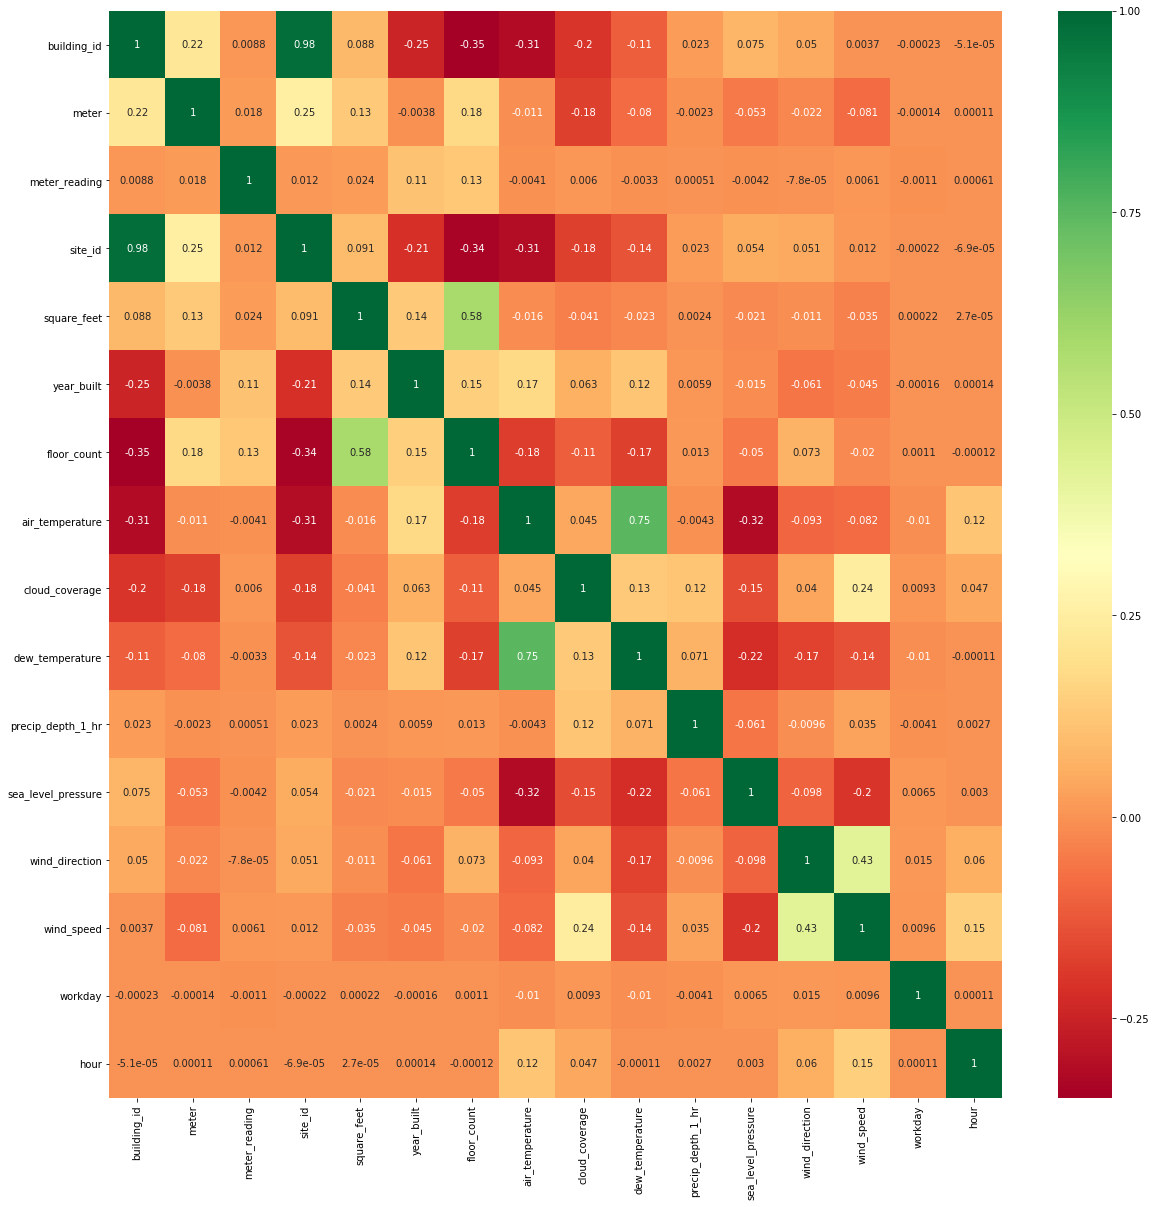

In [19]:
corrmat = fullTraining4.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=seabornInstance.heatmap(fullTraining4[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [35]:
uses = fullTraining4['primary_use'].unique().tolist()
usage_models = {}

for use in uses:
    usage_models[use + "_model"] = fullTraining4.loc[fullTraining4.primary_use == use]

In [36]:
m = usage_models['Education_model']
m[m['meter_reading'] == 0]['meter'].unique().tolist()

[0, 1, 3, 2]

In [38]:
sites = fullTraining4['site_id'].unique().tolist()
site_usage_models = {}
for model in usage_models:
    currModel = usage_models[model]
    for site in sites:
        site_usage_models["site" + str(site) + "_" + model] = currModel.loc[currModel.site_id == site]

In [39]:
meters = fullTraining4['meter'].unique().tolist()
usage_meters_models = {}
for model in site_usage_models:
    currModel = site_usage_models[model]
    for meter in meters:
        usage_meters_models["meter" + str(meter) + "_" + model] = currModel.loc[currModel.meter == meter]

In [44]:
usage_meters_site_workday_models = {}
for model in usage_meters_models:
    usage_meters_site_workday_models["workday_" + model] = usage_meters_models[model].loc[usage_meters_models[model].workday == 0]
    usage_meters_site_workday_models["nonworkday_" + model] = usage_meters_models[model].loc[usage_meters_models[model].workday == 1]

In [55]:
print(usage_meters_site_workday_models.keys())

dict_keys(['workday_meter0_site0_Education_model', 'nonworkday_meter0_site0_Education_model', 'workday_meter1_site0_Education_model', 'nonworkday_meter1_site0_Education_model', 'workday_meter3_site0_Education_model', 'nonworkday_meter3_site0_Education_model', 'workday_meter2_site0_Education_model', 'nonworkday_meter2_site0_Education_model', 'workday_meter0_site1_Education_model', 'nonworkday_meter0_site1_Education_model', 'workday_meter1_site1_Education_model', 'nonworkday_meter1_site1_Education_model', 'workday_meter3_site1_Education_model', 'nonworkday_meter3_site1_Education_model', 'workday_meter2_site1_Education_model', 'nonworkday_meter2_site1_Education_model', 'workday_meter0_site2_Education_model', 'nonworkday_meter0_site2_Education_model', 'workday_meter1_site2_Education_model', 'nonworkday_meter1_site2_Education_model', 'workday_meter3_site2_Education_model', 'nonworkday_meter3_site2_Education_model', 'workday_meter2_site2_Education_model', 'nonworkday_meter2_site2_Education_m

In [35]:
# model = usage_meters_workday_models['nonworkday_Manufacturing/industrial_2_model']
# corrmat = model.corr()
# top_corr_features = corrmat.index
# plt.figure(figsize=(20,20))
# #plot heat map
# g=seabornInstance.heatmap(model[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [53]:
means = {}
for model in usage_meters_site_workday_models:
    means[model + "_mean"] = usage_meters_site_workday_models[model]['meter_reading'].std()

In [5]:
print(means.shape)

NameError: name 'means' is not defined

In [ ]:
regressors = {}
for model in usage_meters_site_workday_models:
    regressors[model] = LinearRegression()
    regressors[model].fit(X_train, y_train)
    for meter in meters:
        usage_meters_models["meter" + str(meter) + "_" + model] = currModel.loc[currModel.meter == meter]

# Decision Tree Model

In [5]:
trainJoinBldg = pd.merge(energyTrain, bldgData, on='building_id')
fullTraining = pd.merge(trainJoinBldg, allWeather, how='left', on=['site_id', 'timestamp'])

In [6]:
fullTraining5 = fullTraining
fullTraining5["timestamp"] = pd.to_datetime(fullTraining5["timestamp"])

In [8]:
#this takes a while (around 3 minutes)
fullTraining5['workday'] = [0 if x.weekday() > 4 else 1 for x in fullTraining5['timestamp']]

In [9]:
sr = fullTraining5['timestamp']
fullTraining5['hour'] = sr.dt.hour

In [10]:
airTempMean = fullTraining5['air_temperature'].mean()
fullTraining5['air_temperature'] - airTempMean
fullTraining5['air_temperature'] = fullTraining5['air_temperature'].abs()
fullTraining5['year_built'] = 2019 - fullTraining5['year_built']

In [43]:
# fullTraining5Dummies = pd.get_dummies(fullTraining5, columns=['meter', 'primary_use', 'site_id'], drop_first=True)

In [18]:
le = preprocessing.LabelEncoder()

In [19]:
le.fit(fullTraining5['primary_use'])

LabelEncoder()

In [23]:
fullTraining5['primary_use'] = le.transform(fullTraining5['primary_use'])

In [57]:
fullTraining5['primary_use'].unique().tolist()

[0, 4, 6, 1, 7, 11, 8, 9, 15, 2, 10, 3, 14, 13, 5, 12]

In [30]:
#Splitting into features and labels
X = fullTraining5[['meter', 'site_id', 'primary_use', 'square_feet',
       'year_built', 'floor_count', 'air_temperature', 'workday', 'hour']].values
y = fullTraining5['meter_reading'].values

In [31]:
#replace null values with column means
indsX = np.where(np.isnan(X))
col_mean = np.nanmean(X, axis=1)
X[indsX] = np.take(col_mean, indsX[1])

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [45]:
model = tree.DecisionTreeRegressor()
model.fit(X, y)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [46]:
model.score(X, y)

0.46961054778219996

In [37]:
predicted = model.predict(X_test)

In [38]:
print(predicted)

[104.5        128.5096       2.8209     ...   0.         367.58136667
 109.568     ]


In [39]:
df = pd.DataFrame({'Actual': y_test, 'Predicted': predicted})
df1 = df.head(25)
df1

,Actual,Predicted
0,109.0000,104.500000
1,17.4250,128.509600
2,4.1231,2.820900
3,1089.8000,1042.270000
4,82.9440,82.944000
5,65.4333,51.275000
6,6.0000,7.214286
7,8.7921,0.000000
8,185.0000,108.666667
9,0.3332,4.748100


In [40]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, predicted))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, predicted))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, predicted)))

Mean Absolute Error: 2456.362356447426
Mean Squared Error: 22552413042.91948
Root Mean Squared Error: 150174.60851595213


In [44]:
y_test.mean()

2157.955900987556

# Testing Tree Model

In [47]:
testJoinBldg = pd.merge(energyTest, bldgData, sort=True, on='building_id')
fullTesting5 = pd.merge(testJoinBldg, allWeather, sort=True, how='left', on=['site_id', 'timestamp'])

In [48]:
fullTesting5["timestamp"] = pd.to_datetime(fullTesting5["timestamp"])

In [49]:
#this takes a while (around 3 minutes)
fullTesting5['workday'] = [0 if x.weekday() > 4 else 1 for x in fullTesting5['timestamp']]

In [50]:
sr = fullTesting5['timestamp']
fullTesting5['hour'] = sr.dt.hour

In [51]:
airTempMean = fullTesting5['air_temperature'].mean()
fullTesting5['air_temperature'] - airTempMean
fullTesting5['air_temperature'] = fullTesting5['air_temperature'].abs()
fullTesting5['year_built'] = 2019 - fullTesting5['year_built']

In [52]:
le_test = preprocessing.LabelEncoder()

In [53]:
le_test.fit(fullTesting5['primary_use'])

LabelEncoder()

In [54]:
fullTesting5['primary_use'] = le_test.transform(fullTesting5['primary_use'])

In [56]:
fullTesting5['primary_use'].unique().tolist()

[0, 4, 6, 1, 7, 11, 8, 9, 15, 2, 10, 3, 14, 13, 5, 12]

In [58]:
#Splitting into features and labels
X_test = fullTesting5[['meter', 'site_id', 'primary_use', 'square_feet',
       'year_built', 'floor_count', 'air_temperature', 'workday', 'hour']].values

In [59]:
#replace null values with column means
indsX = np.where(np.isnan(X_test))
col_mean = np.nanmean(X_test, axis=1)
X_test[indsX] = np.take(col_mean, indsX[1])

In [60]:
y_test_pred = model.predict(X_test)

In [61]:
print(y_test_pred[:5])

[ 54.83233333  19.3847       2.04766667 113.41866667 472.33      ]


In [62]:
print(X_test[:5])

[[0.00000e+00 0.00000e+00 0.00000e+00 7.43200e+03 1.10000e+01 1.00460e+03
  1.78000e+01 0.00000e+00 0.00000e+00]
 [0.00000e+00 0.00000e+00 0.00000e+00 2.72000e+03 1.50000e+01 1.00460e+03
  1.78000e+01 0.00000e+00 0.00000e+00]
 [0.00000e+00 0.00000e+00 0.00000e+00 5.37600e+03 2.80000e+01 1.00460e+03
  1.78000e+01 0.00000e+00 0.00000e+00]
 [0.00000e+00 0.00000e+00 0.00000e+00 2.36850e+04 1.70000e+01 1.00460e+03
  1.78000e+01 0.00000e+00 0.00000e+00]
 [0.00000e+00 0.00000e+00 0.00000e+00 1.16607e+05 4.40000e+01 1.00460e+03
  1.78000e+01 0.00000e+00 0.00000e+00]]


In [63]:
row_ids = fullTesting5['row_id']
pred = pd.DataFrame(y_test_pred)
tree01 = pd.concat([row_ids, pred], axis=1)
tree01.columns = ['row_id', 'meter_reading']

In [64]:
print(tree01.head(5))
print(tree01.columns)
print(tree01.shape)
print(row_ids.head(5))

   row_id  meter_reading
0       0      54.832333
1       1      19.384700
2       2       2.047667
3       3     113.418667
4       4     472.330000
Index(['row_id', 'meter_reading'], dtype='object')
(41697600, 2)
0    0
1    1
2    2
3    3
4    4
Name: row_id, dtype: int64


In [65]:
tree01.to_csv('decisionTree01.csv', index=False)

In [66]:
resultTest = pd.read_csv("decisionTree01.csv")
print(resultTest.head(5))

   row_id  meter_reading
0       0      54.832333
1       1      19.384700
2       2       2.047667
3       3     113.418667
4       4     472.330000


In [67]:
print(resultTest.shape)

(41697600, 2)


In [44]:
y_test.mean()

2157.955900987556